# Heartbeat Sounds

### [Classifying heartbeat anomalies from stethoscope audio](https://www.kaggle.com/kinguistics/heartbeat-sounds)

**Useful Links**

    1. https://github.com/sevenfx/fastai_audio/tree/master/notebooks
    2. https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
    3. https://medium.com/@navdeepsingh_2336/identifying-the-genre-of-a-song-with-neural-networks-851db89c42f0
    4. https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
    5. http://deepsound.io/music_genre_recognition.html
    6. https://medium.com/@juliendespois/finding-the-genre-of-a-song-with-deep-learning-da8f59a61194

### Imports

In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa.display
import shutil
plt.ioff()

PATH = "C:\\Users\\frapo\\Downloads\\heartbeat-sounds"
PATH = "/tmp/data"

ModuleNotFoundError: No module named 'librosa'

### Functions

In [3]:
def load_wave(fname):
    y, sr = librosa.load(os.path.join(PATH, fname))
    return y

def build_dataset():
    path_to_ = os.path.join(PATH, "heartbeats.pkl")
    if os.path.isfile(path_to_):
        df = pd.read_pickle(path_to_)
    else:
        murmurs = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'murmur*.wav')]
        murmurs += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'murmur*.wav')]
        murmurs += murmurs
        labels = ["murmur"] * len(murmurs)
        
        normals = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'normal*.wav')]
        normals += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'normal*.wav')]
        labels += ["normal"] * len(normals)
        
        df = pd.DataFrame({"fname": murmurs+normals, "label": labels})
        df["array"] = df.fname.apply(load_wave)
        df["len_series"] = df["array"].apply(len)
        df['image_names'] = df.fname.apply(lambda x: x.replace("/", "-").replace("wav", "jpg"))
        df = df.sample(frac=1)
        df.to_pickle(path_to_)
    
    return df

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def explore_heartbeat(i):
    print(f"i: {i}")
    label = data.iloc[i].label
    fname = data.iloc[i].fname
    print(f"label: {label}; fname: {fname}")
    if label not in fname: return "Incostintent label"
    
    y, sr = librosa.load(os.path.join(PATH, fname))
    d = librosa.get_duration(y=y, sr=sr)
    print(f"Before padding sr: {sr}; len: {len(y)}; duration (s): {d}")
    
    y_ext = repeat_to_length(y, MAX_LEN)
    d = librosa.get_duration(y=y_ext, sr=sr)
    print(f"After padding sr: {sr}; len: {len(y_ext)}; duration: {d}")
    
    fig, ax = plt.subplots(figsize=(15, 3))
    librosa.display.waveplot(y, sr=sr)
    ax.set_title(f'label={label}; waveplot')
    
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: stft, amp2db, log')
    
    #my_dpi = 120
    #fig, ax = plt.subplots(figsize=(512/my_dpi, 512/my_dpi), dpi=my_dpi)
    
    mfccs = librosa.feature.mfcc(y, sr=sr)
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: mfcc, log')

    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)    
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: melspectrogram, amp2db, log, fmax=2k hz')
    
    plt.show()
    
    return fname, Xdb, y

def get_melspectrogram(y, sr):
    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)  
    return mel_spec_db

def produce_spect_image(spec, sr, name):
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')    
    ax.axis('off')
    plt.savefig(name, bbox_inches=None, pad_inches=0)
    plt.close(fig)
    
def load_and_pad(fname):
    y, sr = librosa.load(fname)
    y = repeat_to_length(y, MAX_LEN)
    return y, sr

def save_spectrograms(df):
    
    directory = os.path.join(PATH, "spects")
    if os.path.exists(directory): shutil.rmtree(directory)
    os.makedirs(directory)
    
    for i, row in df.iterrows():
        fname = os.path.join(PATH, row.fname)
        image_name = os.path.join(directory, row.image_names)
        
        y, sr = load_and_pad(fname)
        spec = get_melspectrogram(y, sr)
        produce_spect_image(spec, sr, image_name)
        
    mxn = df.copy().reset_index()
    mxn["is_murmur"] = mxn.label.apply(lambda x: int(x == "murmur"))
    
    return mxn[["index", "is_murmur", "image_names"]]

def save_lst(x, name):
    x.to_csv(os.path.join(PATH, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(PATH, 'temp.lst'), "rt") as fin:
        with open(os.path.join(PATH, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

### Load dataset and explore

In [4]:
#files = os.listdir(os.path.join(PATH, "spects"))
#d = pd.DataFrame({"files": files})
#e = data.merge(d, left_on="image_names", right_on="files", how="left")
#e.loc[pd.isnull(e.files)]

In [4]:
data = build_dataset()
MAX_LEN = max(data["len_series"])

assert MAX_LEN == 614468
assert isinstance(data.array[0].sum(), np.float32)
assert data.shape == (609, 5)

In [5]:
data.sample(5)

,fname,label,array,len_series,image_names
538,set_b/normal__235_1308749032454_C.wav,normal,"[0.08600582, 0.09440574, 0.09835402, 0.0983057...",26598,set_b-normal__235_1308749032454_C.jpg
383,set_b/normal__106_1306776721273_C1.wav,normal,"[0.012504581, 0.013545132, 0.013790841, 0.0133...",70357,set_b-normal__106_1306776721273_C1.jpg
333,set_b/normal_noisynormal_154_1306935608852_C.wav,normal,"[0.0056475033, 0.006370354, 0.006858137, 0.007...",102494,set_b-normal_noisynormal_154_1306935608852_C.jpg
595,set_a/normal__201105011626.wav,normal,"[-0.0029443733, -0.0052585476, -0.0048129978, ...",198450,set_a-normal__201105011626.jpg
556,set_b/normal__274_1311075637574_B1.wav,normal,"[0.0015704685, 0.0015230937, 0.0013033159, 0.0...",42965,set_b-normal__274_1311075637574_B1.jpg


i: 404
label: normal; fname: set_b/normal__172_1307971284351_B1.wav
Before padding sr: 22050; len: 54971; duration (s): 2.493015873015873
After padding sr: 22050; len: 614468; duration: 27.86702947845805


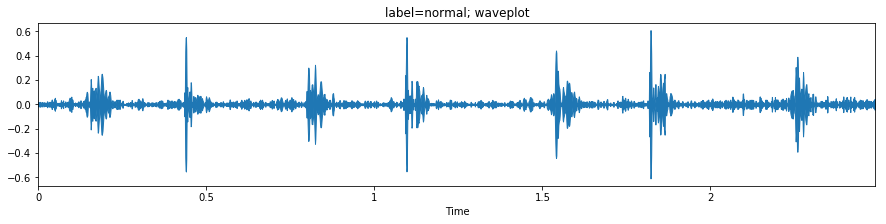

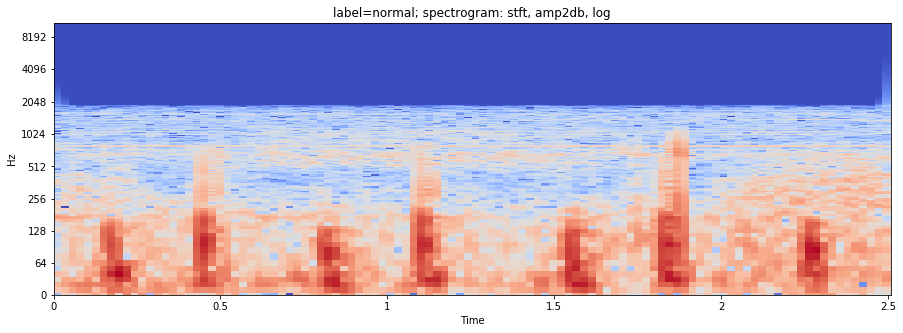

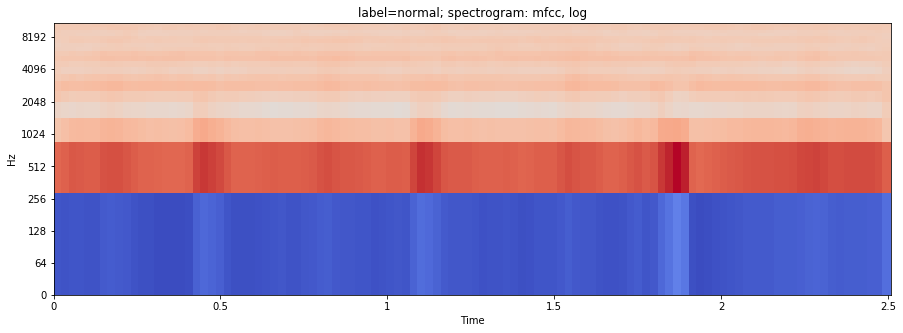

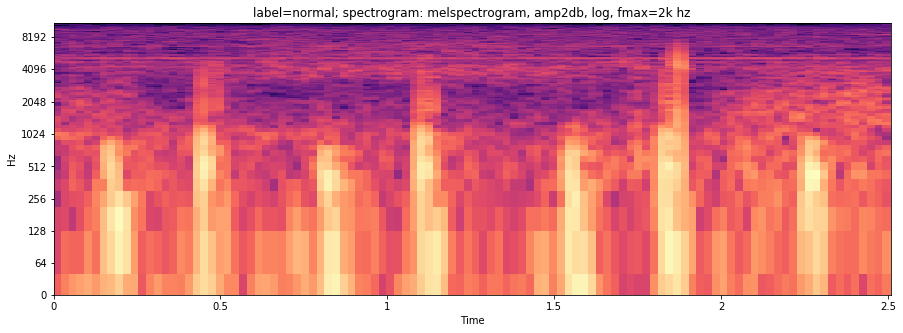

In [6]:
i = np.random.randint(low=0, high=(len(data)-1))
fname, Xdb, y = explore_heartbeat(i)
ipd.Audio(os.path.join(PATH, fname))

### Prepare dataset for Deep Learning

In [11]:
lst = save_spectrograms(data)

In [13]:
assert lst.shape[0] == data.shape[0]

In [17]:
raw_train = lst.sample(int(len(lst)*.8), random_state=42).sample(frac=1)
raw_valid = lst.loc[~lst.index.isin(raw_train.index)].sample(frac=1)

raw_train.shape, raw_valid.shape

((487, 3), (122, 3))

In [20]:
raw_train.is_murmur.sum()/len(raw_train), raw_valid.is_murmur.sum()/len(raw_valid)

(0.4394250513347023, 0.36065573770491804)

In [21]:
save_lst(raw_train, 'train.lst')
save_lst(raw_valid, 'valid.lst')

In [10]:
! head {PATH}/train.lst

168	1	set_b-murmur__160_1307100683334_B.jpg
94	1	set_b-murmur__293_1311680805936_B1.jpg
256	1	set_a-murmur__201108222256.jpg
268	0	set_b-normal_noisynormal_109_1305653972028_A.jpg
87	1	set_b-murmur__281_1311165683454_A.jpg
37	1	set_b-murmur__156_1306936373241_B.jpg
458	0	set_b-normal__168_1307970069434_A.jpg
0	1	set_b-murmur_noisymurmur_135_1306428972976_A.jpg
251	1	set_a-murmur__201108222248.jpg
526	0	set_b-normal__220_1308250132896_C.jpg


## Deep Learning

In [7]:
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import subprocess
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import time
from skimage import io

import mxnet as mx
from mxnet import lr_scheduler
import cv2

In [8]:
def train_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224),
                                    rand_crop=0.5, rand_resize=0.5, 
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def valid_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc, test_loss = evaluate_accuracy(test_iter, net, ctx)
        if test_acc > 0.85:
            print('Validation accuracy > 65%. Saving model...')
            timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
            mod_name = ARCH + timestamp
            net.export(mod_name)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, test_loss, train_acc_sum / m, test_acc,
                 time.time() - start))
    return net
        
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    loss_sum, acc_sum, n, m = 0.0, 0.0, 0, 0
    loss = gloss.SoftmaxCrossEntropyLoss()
    for batch in data_iter:
        Xs, ys, batch_size = _get_batch(batch, ctx)
        y_hats = [net(X) for X in Xs]
        ys = [y.astype('float32') for y in ys]
        ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
        loss_sum += sum([l.sum().asscalar() for l in ls])
        n += sum([l.size for l in ls])
        acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar() for y_hat, y in zip(y_hats, ys)])
        m += sum([y.size for y in ys])        
        
    return acc_sum / m, loss_sum / n

def build_graph(which_net):
    if which_net == 'resnet34':
        pretrained_net = model_zoo.vision.resnet34_v2(pretrained=True)
        finetune_net = model_zoo.vision.resnet34_v2(classes=2)
    if which_net == 'resnet50':
        pretrained_net = model_zoo.vision.resnet50_v2(pretrained=True)
        finetune_net = model_zoo.vision.resnet50_v2(classes=2)
    if which_net == 'vgg16':
        pretrained_net = model_zoo.vision.vgg16_bn(pretrained=True)
        finetune_net = model_zoo.vision.vgg16_bn(classes=2)
    
    finetune_net.features = pretrained_net.features
    finetune_net.output.initialize(init.Xavier())
    return finetune_net

def train_fine_tuning(net, folder, learning_rate, freeze=True, batch_size=32, 
                      num_epochs=5, scheduler=False, wd=0.001, warmup_steps=0):
    
    training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(folder, 'train.rec'), 
                                                           transform=train_aug_transform)
    validation_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(folder, 'valid.rec'), 
                                                            transform=valid_aug_transform)
    
    train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_iter = mx.gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

    ctx = mx.gpu()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()
    
    if freeze:
        params = net.output.collect_params()
    else:
        net.output.collect_params().setattr('lr_mult', 10)
        params = net.collect_params()
    
    
    hyperparams = {'learning_rate': learning_rate}
    if scheduler:
        schedule = lr_scheduler.CosineScheduler(max_update=14, base_lr=learning_rate*100, final_lr=learning_rate, warmup_steps=warmup_steps)
        hyperparams['lr_scheduler'] = schedule
    if wd is not None:
        hyperparams['wd'] = wd
    
    trainer = gluon.Trainer(params, 'adam', hyperparams)
    return train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

In [9]:
training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(PATH, 'train.rec'), transform=train_aug_transform)
train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

In [10]:
x, y = next(iter(train_iter))
x.shape, y.shape

((32, 3, 224, 224), (32,))

In [11]:
ARCH = 'resnet34'
model = build_graph(ARCH)

In [12]:
model = train_fine_tuning(model, PATH, learning_rate=1e-2, freeze=True, num_epochs=10)

training on gpu(0)
epoch 1, train loss 1.6353, test loss 0.7655, train acc 0.540, test acc 0.639, time 17.3 sec
epoch 2, train loss 0.8384, test loss 1.0649, train acc 0.641, test acc 0.508, time 11.3 sec
epoch 3, train loss 0.6011, test loss 0.4675, train acc 0.729, test acc 0.779, time 11.2 sec
epoch 4, train loss 0.4969, test loss 0.5045, train acc 0.791, test acc 0.754, time 11.2 sec
epoch 5, train loss 0.5332, test loss 0.4249, train acc 0.762, test acc 0.811, time 11.3 sec
epoch 6, train loss 0.4860, test loss 0.4365, train acc 0.772, test acc 0.820, time 11.2 sec
epoch 7, train loss 0.4967, test loss 0.4125, train acc 0.786, test acc 0.811, time 11.3 sec
epoch 8, train loss 0.4197, test loss 0.4232, train acc 0.807, test acc 0.820, time 11.7 sec
epoch 9, train loss 0.4595, test loss 0.4692, train acc 0.797, test acc 0.811, time 11.1 sec
epoch 10, train loss 0.4997, test loss 0.4259, train acc 0.789, test acc 0.811, time 11.4 sec


In [ ]:
model = train_fine_tuning(model, PATH, learning_rate=1e-3, freeze=False)

training on gpu(0)
epoch 1, train loss 4.1775, test loss 0.8567, train acc 0.556, test acc 0.459, time 56.7 sec


In [9]:
model = train_fine_tuning(model, PATH, learning_rate=1e-3, freeze=False, scheduler=True)

training on gpu(0)
epoch 1, train loss 973631.2984, test loss 11680555.5410, train acc 0.499, test acc 0.516, time 25.4 sec
epoch 2, train loss 15183.4148, test loss 19475.5456, train acc 0.509, test acc 0.607, time 24.0 sec
epoch 3, train loss 5690.0393, test loss 1073.0236, train acc 0.614, test acc 0.598, time 24.1 sec
epoch 4, train loss 8603.5717, test loss 590.9535, train acc 0.487, test acc 0.598, time 24.1 sec
epoch 5, train loss 5718.7088, test loss 532.9969, train acc 0.571, test acc 0.598, time 24.1 sec


### SageMaker tests

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [15]:
from sagemaker.mxnet import MXNet
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import random_tuner as rt

In [15]:
from cifar10_utils import download_training_data
download_training_data()

downloading training data...
done


In [12]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-gluon-cifar10')
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-eu-west-1-257446244580/data/DEMO-gluon-cifar10


In [13]:
inputs

's3://sagemaker-eu-west-1-257446244580/data/DEMO-gluon-cifar10'

In [38]:
m = MXNet('heartsound_mxnet.py', 
          role=role, 
          train_instance_count=1, 
          py_version='py3',
          train_instance_type='ml.p2.xlarge',
          hyperparameters={'batch_size': 16, 
                           'epochs': 5})

In [39]:
m.fit("s3://heartbeat-sounds")

2019-06-05 15:45:57 Starting - Starting the training job...
2019-06-05 15:45:59 Starting - Launching requested ML instances.........
2019-06-05 15:47:31 Starting - Preparing the instances for training...
2019-06-05 15:48:26 Downloading - Downloading input data.........
2019-06-05 15:49:29 Training - Downloading the training image.
2019-06-05 15:50:01,010 INFO - root - running container entrypoint
2019-06-05 15:50:01,010 INFO - root - starting train task
2019-06-05 15:50:01,031 INFO - container_support.training - Training starting
2019-06-05 15:50:02,271 WARNING - mxnet_container.train - #033This required structure for training scripts will be deprecated with the next major release of MXNet images. The train() function will no longer be required; instead the training script must be able to be run as a standalone script. For more information, see https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/mxnet#updating-your-mxnet-training-script.#033
2019-06-05 15:50:03,691 IN

In [22]:
mt = MXNet('heartsound_mxnet.py', 
          role=role, 
          train_instance_count=1, 
          py_version='py3',
          train_instance_type='ml.p2.xlarge',
          hyperparameters={'batch_size': 16})

No framework_version specified, defaulting to version 1.2. This is not the latest supported version. If you would like to use version 1.3, please add framework_version=1.3 to your constructor.


In [23]:
hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.0001, 0.1),
                         'momentum': ContinuousParameter(0., 0.99),
                         'wd': ContinuousParameter(0., 0.001),
                         'epochs': IntegerParameter(5, 10),
                         'opt': CategoricalParameter(['sgd', 'adam'])}

In [24]:
objective_metric_name = 'Validation-accuracy'
metric_definitions = [{'Name': 'Validation-accuracy',
                       'Regex': 'validation: accuracy=([0-9\\.]+)'}]

In [25]:
tuner = HyperparameterTuner(mt,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=15)

In [26]:
tuner.fit("s3://heartbeat-sounds")

In [31]:
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner._current_job_name).dataframe()
bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False, inplace=True)

In [36]:
bayes_metrics.rename(index=str, columns={"FinalObjectiveValue": "validation_accuracy"}, inplace=True)
bayes_metrics[["validation_accuracy", "epochs", "learning_rate", "momentum", "opt", "wd"]]

,validation_accuracy,epochs,learning_rate,momentum,opt,wd
14,0.964286,10.0,0.000435,0.850335,"""adam""",0.000869
4,0.945312,9.0,0.000136,0.959620,"""sgd""",0.000507
3,0.919643,10.0,0.000763,0.974411,"""sgd""",0.000799
7,0.919643,10.0,0.001152,0.959002,"""adam""",0.000957
12,0.898438,8.0,0.002237,0.914738,"""adam""",0.000920
0,0.892857,5.0,0.000120,0.988601,"""sgd""",0.000000
1,0.892857,10.0,0.000105,0.989206,"""sgd""",0.000866
9,0.892857,10.0,0.009198,0.419034,"""adam""",0.000981
11,0.890625,9.0,0.000900,0.786290,"""adam""",0.000246
10,0.883929,10.0,0.000213,0.980358,"""adam""",0.000785
